In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

In [4]:
from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


In [5]:
import os

In [9]:
os.chdir('C:/Users/arjun/OneDrive/Desktop/Arjun')

In [6]:
os.getcwd()

'C:\\Users\\arjun'

In [8]:
df = pd.read_csv("Cancer Data.csv")

In [9]:
df.head()

,Patient,ID,age,eventdeath,survival,timerecurrence,chemo,hormonal,amputation,histtype,...,Contig36312_RC,Contig38980_RC,NM_000853,NM_000854,NM_000860,Contig29014_RC,Contig46616_RC,NM_000888,NM_000898,AF067420
0,s122,18,43,0,14.817248,14.817248,0,0,1,1,...,0.591103,-0.355018,0.373644,-0.760690,-0.164025,-0.038726,0.237856,-0.087631,-0.369153,0.153795
1,s123,19,48,0,14.261465,14.261465,0,0,0,1,...,-0.199829,-0.001635,-0.062922,-0.682204,-0.220934,-0.100088,-0.466537,-0.231547,-0.643019,-0.014098
2,s124,20,38,0,6.644764,6.644764,0,0,0,1,...,0.328736,-0.047571,0.084228,-0.695950,-0.402840,-0.099965,0.110155,-0.114298,0.258495,-0.198911
3,s125,21,50,0,7.748118,7.748118,0,1,0,1,...,0.648861,-0.039088,0.182182,-0.524640,0.037320,-0.167688,-0.016790,-0.285344,-0.251188,0.862710
4,s126,22,38,0,6.436687,6.318960,0,0,1,1,...,-0.287538,-0.286893,0.057082,-0.565021,-0.105632,-0.108148,-0.405853,-0.053601,-0.677072,0.134160


In [10]:
print(df.isnull().sum()) 
print(df.shape)

Patient           0
ID                0
age               0
eventdeath        0
survival          0
                 ..
Contig29014_RC    0
Contig46616_RC    0
NM_000888         0
NM_000898         0
AF067420          0
Length: 1570, dtype: int64
(272, 1570)


In [11]:
df = df.iloc[:, 0:15]

In [12]:
df.head()

,Patient,ID,age,eventdeath,survival,timerecurrence,chemo,hormonal,amputation,histtype,diam,posnodes,grade,angioinv,lymphinfil
0,s122,18,43,0,14.817248,14.817248,0,0,1,1,25,0,2,3,1
1,s123,19,48,0,14.261465,14.261465,0,0,0,1,20,0,3,3,1
2,s124,20,38,0,6.644764,6.644764,0,0,0,1,15,0,2,1,1
3,s125,21,50,0,7.748118,7.748118,0,1,0,1,15,1,2,3,1
4,s126,22,38,0,6.436687,6.318960,0,0,1,1,15,0,2,2,1


In [13]:
df.set_index('Patient', inplace = True)

In [ ]:
#Check censored data
#For alive = 1 patients, because they are alive during data collection period and we do not know their survival months after the data collection, they are regarded as censored data. 
#Hence, the following analysis needs to consider the censored data by making dead variable below.

In [14]:
df.groupby('eventdeath').count()

,ID,age,survival,timerecurrence,chemo,hormonal,amputation,histtype,diam,posnodes,grade,angioinv,lymphinfil
eventdeath,,,,,,,,,,,,,
0,195,195,195,195,195,195,195,195,195,195,195,195,195
1,77,77,77,77,77,77,77,77,77,77,77,77,77


In [15]:
#We have 195 non-censored data and 77 censored data

# Kaplan Meier estimates

In [17]:
kmf = KaplanMeierFitter()
kmf.fit(df['age'], event_observed = df['eventdeath'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 272 total observations, 195 right-censored observations>

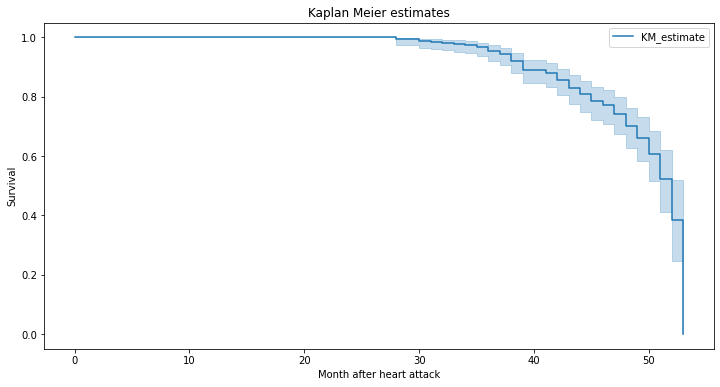

In [18]:
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")
plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, s122 to s76
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              272 non-null    int64  
 1   age             272 non-null    int64  
 2   eventdeath      272 non-null    int64  
 3   survival        272 non-null    float64
 4   timerecurrence  272 non-null    float64
 5   chemo           272 non-null    int64  
 6   hormonal        272 non-null    int64  
 7   amputation      272 non-null    int64  
 8   histtype        272 non-null    int64  
 9   diam            272 non-null    int64  
 10  posnodes        272 non-null    int64  
 11  grade           272 non-null    int64  
 12  angioinv        272 non-null    int64  
 13  lymphinfil      272 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 31.9+ KB


# Cox Proportional Hazard Model (Survival Regression)

In [20]:
from lifelines import CoxPHFitter

In [23]:
df.head()

,age,eventdeath,survival,timerecurrence,chemo,hormonal,amputation,histtype,diam,posnodes,grade,angioinv,lymphinfil
Patient,,,,,,,,,,,,,
s122,43,0,14.817248,14.817248,0,0,1,1,25,0,2,3,1
s123,48,0,14.261465,14.261465,0,0,0,1,20,0,3,3,1
s124,38,0,6.644764,6.644764,0,0,0,1,15,0,2,1,1
s125,50,0,7.748118,7.748118,0,1,0,1,15,1,2,3,1
s126,38,0,6.436687,6.318960,0,0,1,1,15,0,2,2,1


In [27]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df, 'age', event_col='eventdeath')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 272 total observations, 195 right-censored observations>
             duration col = 'age'
                event col = 'eventdeath'
      baseline estimation = breslow
   number of observations = 272
number of events observed = 77
   partial log-likelihood = -293.52
         time fit was run = 2020-12-07 03:11:54 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
survival         0.05       1.05       0.07            -0.08             0.18                 0.92                 1.20
timerecurrence  -0.41       0.66       0.07            -0.56            -0.27                 0.57                 0.76
chemo           -0.17       0.84       0.32            -0.80             0.46                 0.45                 1.58
hormonal        -1.65       0.19       0.49            -2.62            -0.68                 0.07                 0.50
amputation      -0.08       0.92       0.25            -0.57             0.41                 0.56                 1.51
histtype         0.01       1.01       0.28            -0.53             0.56                 0.59                 1.74
diam            -0.00       1.00       0.02            -0.04             0.03                 0.96                 1.03
posnodes         0.14       1.16       0.06             0.03             0.25                 1.03                 1.29
grade            0.59       1.81       0.23             0.15             1.04                 1.16                 2.82
angioinv         0.05       1.05       0.14            -0.22             0.31                 0.81                 1.37
lymphinfil       0.10       1.11       0.21            -0.30             0.51                 0.74                 1.66

                   z      p   -log2(p)
covariate                             
survival        0.71   0.48       1.07
timerecurrence -5.65 <0.005      25.87
chemo          -0.53   0.60       0.75
hormonal       -3.34 <0.005      10.25
amputation     -0.32   0.75       0.42
histtype        0.05   0.96       0.05
diam           -0.16   0.87       0.20
posnodes        2.57   0.01       6.61
grade           2.63   0.01       6.86
angioinv        0.37   0.71       0.48
lymphinfil      0.49   0.62       0.68
---
Concordance = 0.88
Partial AIC = 609.05
log-likelihood ratio test = 148.82 on 11 df
-log2(p) of ll-ratio test = 84.99

In [29]:
tr_rows = df.iloc[0:6, 2:]
tr_rows

,survival,timerecurrence,chemo,hormonal,amputation,histtype,diam,posnodes,grade,angioinv,lymphinfil
Patient,,,,,,,,,,,
s122,14.817248,14.817248,0,0,1,1,25,0,2,3,1
s123,14.261465,14.261465,0,0,0,1,20,0,3,3,1
s124,6.644764,6.644764,0,0,0,1,15,0,2,1,1
s125,7.748118,7.748118,0,1,0,1,15,1,2,3,1
s126,6.436687,6.318960,0,0,1,1,15,0,2,2,1
s127,5.037645,2.743326,1,0,1,1,10,1,1,1,1


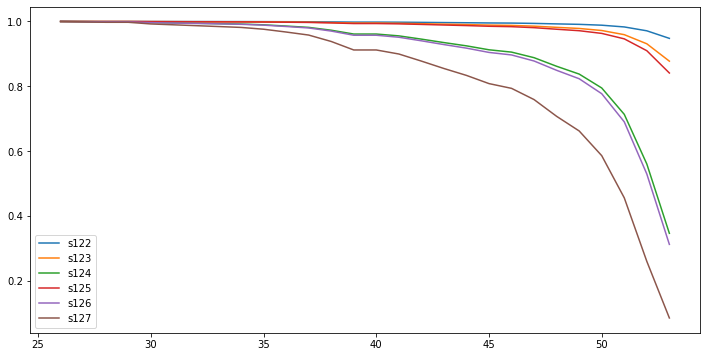

In [30]:
## Lets predict the survival curve for the selected customers. 
## Customers can be identified with the help of the number mentioned against each curve.
cph.predict_survival_function(tr_rows).plot()

## Several interpretations cane be made from this graph. For example, it can be interpreted that the probability of patient s122 living beyond 50 months from fitst attack is very high (close to 100%). This is in contrast to patient s127 whose probability of living beyond 50 months drastically drops